ACTOR-CRITIC (A2C) TRAINING

In [1]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 1: IMPORTS AND SETUP
# ═══════════════════════════════════════════════════════════════════════════
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

# Add parent directory to path for imports (for Jupyter notebook)
if '..' not in sys.path:
    sys.path.append('..')

from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from environment.custom_env import FireRescueEnv

print("✓ All imports successful")
print(f"Working Directory: {os.getcwd()}")

✓ All imports successful
Working Directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training


In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 2: A2C HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════════
"""
Key A2C Hyperparameters:
- learning_rate: Step size for gradient updates
- gamma: Discount factor (how much to value future rewards)
- n_steps: Number of steps to run for each environment per update
- ent_coef: Entropy coefficient (encourages exploration) - FIXED: Increased from 0.01 to 0.05
- vf_coef: Value function coefficient
- gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
- max_grad_norm: Maximum value for gradient clipping

Note: Some configs are similar to DQN where applicable (lr, gamma, network arch)
to enable cross-algorithm comparison.

CRITICAL FIX: Entropy coefficients increased from 0.01 to 0.05 (matching PPO)
to prevent action space collapse. Agent was only using movement actions.
"""

A2C_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE (Standard A2C settings)
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard A2C settings (FIXED exploration)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Similar to DQN config_2)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,  # Very high
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - May cause instability (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Similar to DQN config_3)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,  # Very low
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Slow but stable learning (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LOW GAMMA (Similar to DQN config_6)
    # ─────────────────────────────────────────────────────────────────────
    "config_4_low_gamma": {
        "learning_rate": 7e-4,
        "gamma": 0.95,  # Short-term focus
        "n_steps": 5,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Myopic policy (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: HIGH ENTROPY (More exploration)
    # ─────────────────────────────────────────────────────────────────────
    "config_5_high_entropy": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.1,  # High entropy = more exploration
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Entropy - Increased exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW ENTROPY (More exploitation)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_entropy": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.001,  # Low entropy = more exploitation
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Entropy - More exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: MANY STEPS (Longer rollouts)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_many_steps": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 20,  # Longer rollouts
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Many Steps - Longer rollouts (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FEW STEPS (Shorter rollouts, more frequent updates)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_few_steps": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 2,  # Very short rollouts
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Few Steps - Frequent updates (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: HIGH VALUE FUNCTION WEIGHT
    # ─────────────────────────────────────────────────────────────────────
    "config_9_high_vf": {
        "learning_rate": 7e-4,
        "gamma": 0.99,
        "n_steps": 5,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 1.0,  # Higher value function weight
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High VF Coef - Emphasizes value learning (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: DEEP NETWORK (Similar to DQN config_10)
    # ─────────────────────────────────────────────────────────────────────
    "config_10_deep_net": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "n_steps": 10,
        "ent_coef": 0.05,  # FIXED: Increased from 0.01
        "vf_coef": 0.5,
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper network
        "description": "Deep Network - More capacity (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: OPTIMIZED (Best combination for fire-rescue task)
    # ─────────────────────────────────────────────────────────────────────
    "config_11_optimized": {
        "learning_rate": 5e-4,
        "gamma": 0.99,
        "n_steps": 8,
        "ent_coef": 0.06,  # FIXED: Increased from 0.02 for better exploration
        "vf_coef": 0.6,
        "gae_lambda": 0.98,  # Higher GAE lambda for smoother advantage
        "max_grad_norm": 0.5,
        "policy_kwargs": dict(net_arch=[128, 64]),  # Asymmetric network
        "description": "Optimized - Balanced for task (FIXED)"
    },
}

# Print configuration summary
print(f"\n✓ Defined {len(A2C_CONFIGS)} A2C configurations (FIXED exploration)")
print("=" * 120)
print(f"{'Config':<25} {'LR':<10} {'Gamma':<8} {'Steps':<8} {'Ent':<8} {'VF':<8} {'GAE':<8} {'Network':<15}")
print("=" * 120)

for name, config in A2C_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{name:<25} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['n_steps']:<8} {config['ent_coef']:<8.3f} {config['vf_coef']:<8.2f} "
          f"{config['gae_lambda']:<8.3f} {net_arch:<15}")

print("=" * 120)
print("\n🔧 CRITICAL FIXES APPLIED:")
print("  • Entropy coefficient increased from 0.01 to 0.05 (matching PPO)")
print("  • Prevents action space collapse (agent using all 6 actions)")
print("  • Encourages exploration of SCAN and PICKUP actions")
print("\nCross-Algorithm Comparisons:")
print("  • Configs 2, 3: Similar to DQN - test learning rate extremes")
print("  • Config 4: Similar to DQN - test discount factor")
print("  • Config 10: Similar to DQN - deep network architecture")
print("\nA2C-Specific Variations:")
print("  • Configs 5, 6: Entropy coefficient (exploration vs exploitation)")
print("  • Configs 7, 8: Rollout length (n_steps)")
print("  • Config 9: Value function emphasis")
print("  • Config 11: Optimized for fire-rescue task")
print("=" * 120)


✓ Defined 11 A2C configurations (FIXED exploration)
Config                    LR         Gamma    Steps    Ent      VF       GAE      Network        
config_1_baseline         7e-04      0.990    5        0.050    0.50     0.950    [64, 64]       
config_2_high_lr          5e-03      0.990    5        0.050    0.50     0.950    [64, 64]       
config_3_low_lr           1e-05      0.990    5        0.050    0.50     0.950    [64, 64]       
config_4_low_gamma        7e-04      0.950    5        0.050    0.50     0.950    [64, 64]       
config_5_high_entropy     7e-04      0.990    5        0.100    0.50     0.950    [64, 64]       
config_6_low_entropy      7e-04      0.990    5        0.001    0.50     0.950    [64, 64]       
config_7_many_steps       7e-04      0.990    20       0.050    0.50     0.950    [64, 64]       
config_8_few_steps        7e-04      0.990    2        0.050    0.50     0.950    [64, 64]       
config_9_high_vf          7e-04      0.990    5        0.050    1

In [3]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: TRAINING CALLBACK AND UTILITIES
# ═══════════════════════════════════════════════════════════════════════════

class TrainingCallback(BaseCallback):
    """Callback to track training metrics - FIXED to match PPO approach"""
    
    def __init__(self, eval_freq=1000, verbose=0):
        super().__init__(verbose)
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0
        
    def _on_step(self) -> bool:
        # FIXED: Use ep_info_buffer like PPO to get accurate episode info
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                if 'r' in info:
                    self.episode_rewards.append(info['r'])
                if 'l' in info:
                    self.episode_lengths.append(info['l'])
                self.episode_count += 1
                
        return True

def evaluate_policy(model, env, n_episodes=100, verbose=False):
    """Evaluate trained policy with detailed metrics matching PPO notebook"""
    episode_rewards = []
    episode_lengths = []
    wall_collision_rates = []
    scan_efficiencies = []
    pickup_attempts_list = []
    time_to_find_survivor_list = []
    
    for episode_num in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated
        
        # CRITICAL FIX: Extract metrics from final info (only available at episode end)
        episode_rewards.append(episode_reward)
        episode_lengths.append(info.get('episode_length', 0))
        wall_collision_rates.append(info.get('wall_collision_rate', 0))
        scan_efficiencies.append(info.get('scan_efficiency', 0))
        pickup_attempts_list.append(info.get('pickup_attempts', 0))
        
        time_found = info.get('time_to_find_survivor', None)
        if time_found is not None:
            time_to_find_survivor_list.append(time_found)
        
        # Debug output for first 5 episodes
        if verbose and episode_num < 5:
            print(f"  Episode {episode_num+1}: "
                  f"Steps: {info.get('episode_length', 0)} | "
                  f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                  f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
    
    if verbose:
        print(f"\n📊 Evaluation Summary:")
        print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
        print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
        print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
        print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
        if time_to_find_survivor_list:
            print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/{n_episodes} found)")
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_length': np.mean(episode_lengths),
        'wall_collision_rate': np.mean(wall_collision_rates),
        'scan_efficiency': np.mean(scan_efficiencies),
        'avg_pickup_attempts': np.mean(pickup_attempts_list),
        'avg_time_to_find_survivor': np.mean(time_to_find_survivor_list) if time_to_find_survivor_list else None,
        'survivor_found_count': len(time_to_find_survivor_list),
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'wall_collision_rates': wall_collision_rates,
        'scan_efficiencies': scan_efficiencies,
        'pickup_attempts': pickup_attempts_list,
        'time_to_find_survivor': time_to_find_survivor_list,
    }

print("✓ Training utilities defined (FIXED to match PPO)")

✓ Training utilities defined (FIXED to match PPO)


In [4]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: TRAIN ALL CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════════

TOTAL_TIMESTEPS = 100_000
EVAL_EPISODES = 50
results = {}

print(f"\n{'='*120}")
print(f"TRAINING ALL {len(A2C_CONFIGS)} CONFIGURATIONS")
print(f"Total timesteps per config: {TOTAL_TIMESTEPS:,}")
print(f"{'='*120}\n")

for config_name, config in A2C_CONFIGS.items():
    print(f"\n{'─'*120}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'─'*120}")
    
    # Create environment
    env = FireRescueEnv(grid_size=10, max_time=250)
    
    # Extract hyperparameters
    model_params = {k: v for k, v in config.items() if k not in ['description']}
    
    # Create model
    model = A2C("MlpPolicy", env, verbose=0, **model_params)
    
    # Create callback
    callback = TrainingCallback()
    
    # Train
    start_time = datetime.now()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback, progress_bar=False)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Evaluate
    print(f"\nFinal evaluation ({EVAL_EPISODES} episodes)...")
    print(f"Calculating episode performance metrics...")
    eval_results = evaluate_policy(model, env, n_episodes=EVAL_EPISODES, verbose=True)
    
    # Store results
    results[config_name] = {
        'config': config,
        'callback': callback,
        'eval_results': eval_results,
        'train_time': train_time,
        'model': model
    }
    
    # Print summary
    print(f"\n{'='*120}")
    print(f"RESULTS for {config_name}:")
    print(f"   Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
    print(f"   Avg Episode Length: {eval_results['mean_length']:.1f} steps")
    print(f"   Wall Collision Rate: {eval_results['wall_collision_rate']:.2%}")
    print(f"   Scan Efficiency: {eval_results['scan_efficiency']:.2%}")
    print(f"   Avg Pickup Attempts: {eval_results['avg_pickup_attempts']:.2f}")
    if eval_results['avg_time_to_find_survivor'] is not None:
        print(f"   Avg Time to Find Survivor: {eval_results['avg_time_to_find_survivor']:.1f} steps")
    print(f"   Training Time: {train_time:.1f}s ({train_time/60:.1f} min)")
    print(f"{'='*120}")
    
    # ═══════════════════════════════════════════════════════════════════════
    # SAVE MODEL AND RESULTS IMMEDIATELY AFTER TRAINING
    # ═══════════════════════════════════════════════════════════════════════
    print(f"\n💾 Saving {config_name} model and results...")
    
    # Create directory for this configuration
    config_dir = Path(f"../models/a2c/{config_name}")
    config_dir.mkdir(parents=True, exist_ok=True)
    
    # Save the trained model
    model.save(config_dir / f"{config_name}_model")
    print(f"   ✓ Model saved: {config_dir}/{config_name}_model.zip")
    
    # Save configuration
    config_to_save = {k: v for k, v in config.items() if k != 'policy_kwargs'}
    config_to_save['policy_kwargs'] = str(config['policy_kwargs'])
    with open(config_dir / "config.json", 'w') as f:
        json.dump(config_to_save, f, indent=2)
    print(f"   ✓ Config saved: {config_dir}/config.json")
    
    # Save evaluation results
    results_to_save = {
        'mean_reward': eval_results['mean_reward'],
        'std_reward': eval_results['std_reward'],
        'mean_length': eval_results['mean_length'],
        'wall_collision_rate': eval_results['wall_collision_rate'],
        'scan_efficiency': eval_results['scan_efficiency'],
        'avg_pickup_attempts': eval_results['avg_pickup_attempts'],
        'avg_time_to_find_survivor': eval_results['avg_time_to_find_survivor'],
        'survivor_found_count': eval_results['survivor_found_count'],
        'train_time': train_time,
        'total_timesteps': TOTAL_TIMESTEPS,
        'eval_episodes': EVAL_EPISODES,
        'timestamp': datetime.now().isoformat()
    }
    
    with open(config_dir / "results.json", 'w') as f:
        json.dump(results_to_save, f, indent=2)
    print(f"   ✓ Results saved: {config_dir}/results.json")
    
    # Save detailed episode data as numpy arrays
    np.savez(
        config_dir / "episode_data.npz",
        episode_rewards=np.array(eval_results['episode_rewards']),
        episode_lengths=np.array(eval_results['episode_lengths']),
        wall_collision_rates=np.array(eval_results['wall_collision_rates']),
        scan_efficiencies=np.array(eval_results['scan_efficiencies']),
        pickup_attempts=np.array(eval_results['pickup_attempts']),
        time_to_find_survivor=np.array(eval_results['time_to_find_survivor'])
    )
    print(f"   ✓ Episode data saved: {config_dir}/episode_data.npz")
    
    print(f"✅ {config_name} fully saved!\n")
    
    env.close()

print(f"\n{'='*120}")
print("ALL TRAINING COMPLETED")
print(f"{'='*120}\n")



TRAINING ALL 11 CONFIGURATIONS
Total timesteps per config: 100,000


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training: config_1_baseline
Description: Baseline - Standard A2C settings (FIXED exploration)
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final evaluation (50 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%

Final evaluation (50 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 3: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 96.79% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | 


LOADING SAVED RESULTS AND VISUALIZING

Current working directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training
Looking for models in: c:\Users\HP\Programming\ML\fire_rescue_agent\models\a2c
Models directory exists: True

Found 11 configurations:

  ✓ config_10_deep_net: Mean Reward = -82.95
  ✓ config_11_optimized: Mean Reward = 4.62
  ✓ config_1_baseline: Mean Reward = -33.63
  ✓ config_2_high_lr: Mean Reward = -24.42
  ✓ config_3_low_lr: Mean Reward = 0.10
  ✓ config_4_low_gamma: Mean Reward = 10.98
  ✓ config_5_high_entropy: Mean Reward = 50.15
  ✓ config_6_low_entropy: Mean Reward = 8.65
  ✓ config_7_many_steps: Mean Reward = -14.20
  ✓ config_8_few_steps: Mean Reward = 11.97
  ✓ config_9_high_vf: Mean Reward = -8.89


  ✓ config_3_low_lr: Mean Reward = 0.10
  ✓ config_4_low_gamma: Mean Reward = 10.98
  ✓ config_5_high_entropy: Mean Reward = 50.15
  ✓ config_6_low_entropy: Mean Reward = 8.65
  ✓ config_7_many_steps: Mean Reward = -14.20
  ✓ config_8_few_steps: Mean Reward

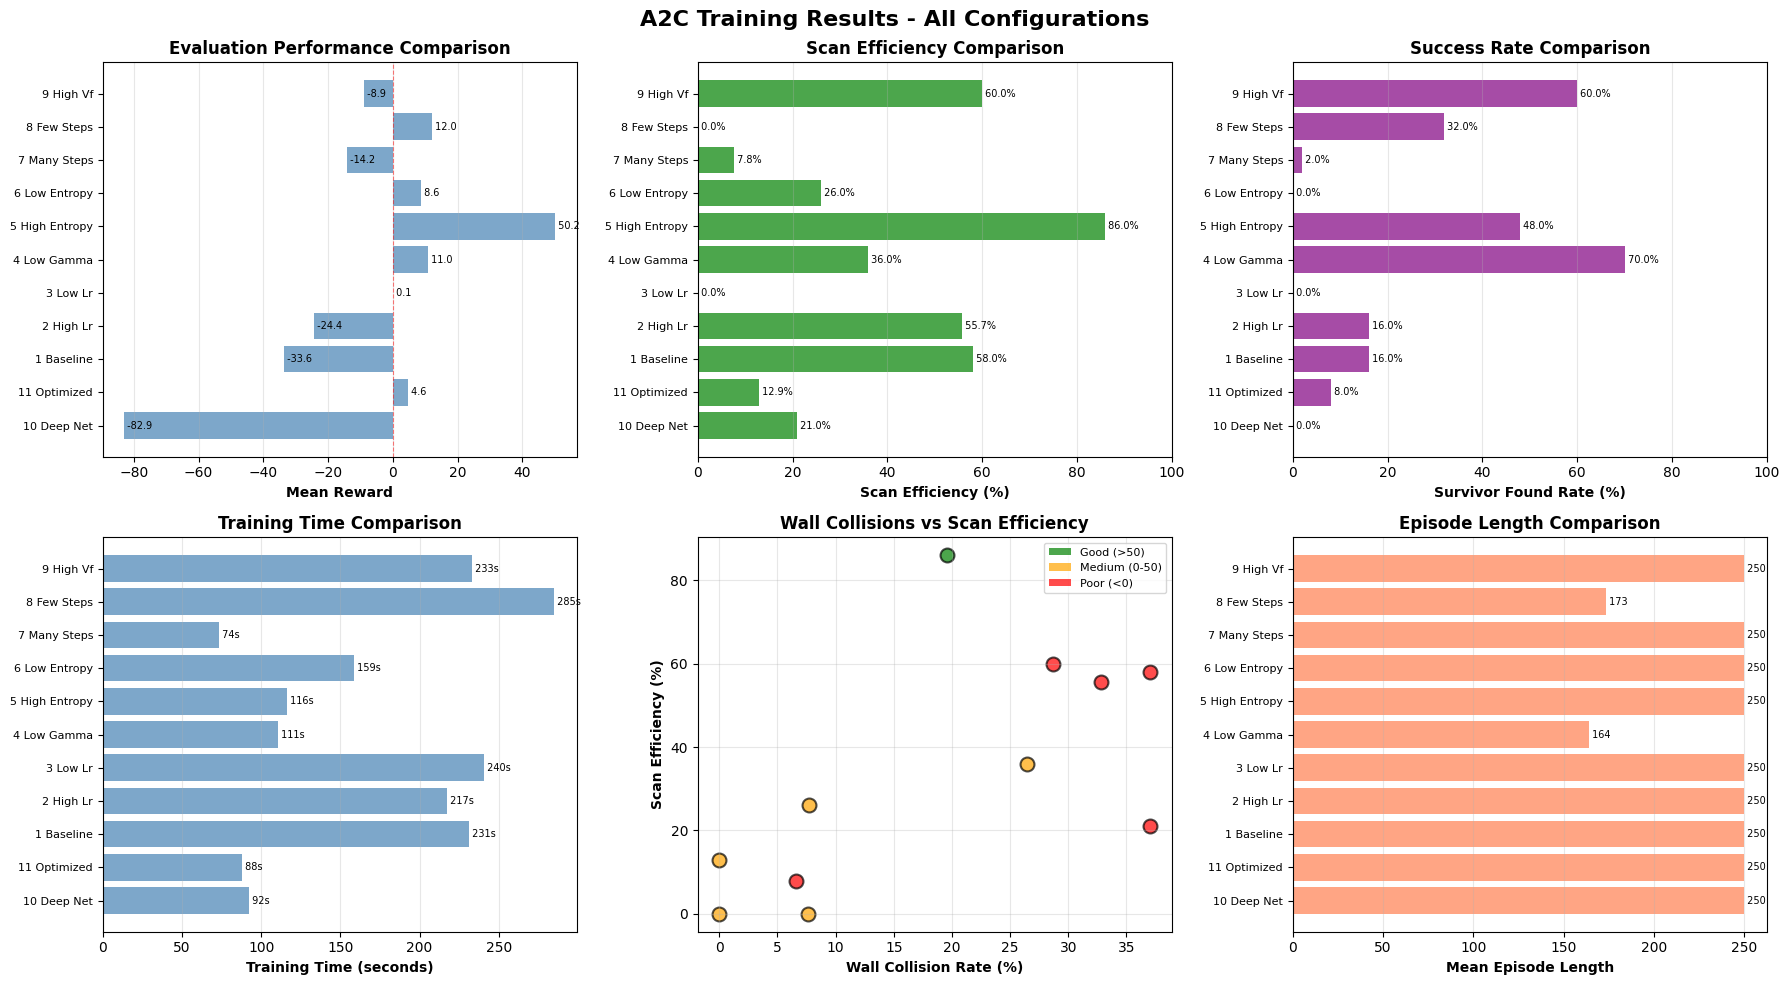

✓ Overall training visualizations complete

Note: This cell now loads from saved results and can run independently!


In [5]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 5: OVERALL TRAINING VISUALIZATIONS (ALL CONFIGURATIONS)
# ═══════════════════════════════════════════════════════════════════════════
# FIXED: Now loads from saved results instead of requiring training run
# This cell can be run independently without running Cell 4

print(f"\n{'='*120}")
print("LOADING SAVED RESULTS AND VISUALIZING")
print(f"{'='*120}\n")

# Get the correct path to models directory
# Handle both cases: running from training/ or from project root
current_dir = Path.cwd()
print(f"Current working directory: {current_dir}")

# Try to find the models directory
if (current_dir / "models" / "a2c").exists():
    models_dir = current_dir / "models" / "a2c"
elif (current_dir.parent / "models" / "a2c").exists():
    models_dir = current_dir.parent / "models" / "a2c"
elif (current_dir / ".." / "models" / "a2c").exists():
    models_dir = Path(current_dir / ".." / "models" / "a2c").resolve()
else:
    models_dir = Path("../models/a2c")

print(f"Looking for models in: {models_dir}")
print(f"Models directory exists: {models_dir.exists()}\n")

loaded_results = {}

# Check if directory exists
if not models_dir.exists():
    print(f"❌ ERROR: Directory {models_dir} does not exist!")
    print("Please run Cell 4 first to train the models.")
else:
    # Get all config directories
    config_dirs = [d for d in models_dir.iterdir() if d.is_dir() and d.name.startswith('config_')]
    config_dirs.sort()
    
    print(f"Found {len(config_dirs)} configurations:\n")
    
    for config_dir in config_dirs:
        config_name = config_dir.name
        results_file = config_dir / "results.json"
        
        if results_file.exists():
            try:
                with open(results_file, 'r') as f:
                    result_data = json.load(f)
                loaded_results[config_name] = result_data
                print(f"  ✓ {config_name}: Mean Reward = {result_data['mean_reward']:.2f}")
            except Exception as e:
                print(f"  ✗ {config_name}: Error loading results.json - {e}")
        else:
            print(f"  ✗ {config_name}: No results.json found")
    
    print(f"\n{'='*120}\n")
    
    # Only create visualizations if we have data
    if len(loaded_results) == 0:
        print("❌ No configuration results found!")
        print("Please run Cell 4 first to train the models.")
    else:
        # Create visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('A2C Training Results - All Configurations', fontsize=16, fontweight='bold')
        
        config_names = sorted(loaded_results.keys())
        colors = ['steelblue' for _ in config_names]
        
        # 1. Mean Evaluation Rewards (Bar Chart)
        ax = axes[0, 0]
        mean_rewards = [loaded_results[c]['mean_reward'] for c in config_names]
        
        bars = ax.barh(range(len(config_names)), mean_rewards, color=colors, alpha=0.7)
        ax.set_yticks(range(len(config_names)))
        ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                             for c in config_names], fontsize=8)
        ax.set_xlabel('Mean Reward', fontweight='bold')
        ax.set_title('Evaluation Performance Comparison', fontweight='bold')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, mean_rewards)):
            ax.text(val, i, f' {val:.1f}', va='center', fontsize=7)
        
        # 2. Scan Efficiency (Bar Chart)
        ax = axes[0, 1]
        scan_efficiencies = [loaded_results[c]['scan_efficiency'] * 100 for c in config_names]
        bars = ax.barh(range(len(config_names)), scan_efficiencies, color='green', alpha=0.7)
        ax.set_yticks(range(len(config_names)))
        ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                             for c in config_names], fontsize=8)
        ax.set_xlabel('Scan Efficiency (%)', fontweight='bold')
        ax.set_title('Scan Efficiency Comparison', fontweight='bold')
        ax.set_xlim(0, 100)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, scan_efficiencies)):
            ax.text(val, i, f' {val:.1f}%', va='center', fontsize=7)
        
        # 3. Survivor Found Rate (Bar Chart) - REPLACED training curves
        ax = axes[0, 2]
        survivor_found_pct = [(loaded_results[c]['survivor_found_count'] / loaded_results[c]['eval_episodes'] * 100) 
                              for c in config_names]
        bars = ax.barh(range(len(config_names)), survivor_found_pct, color='purple', alpha=0.7)
        ax.set_yticks(range(len(config_names)))
        ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                             for c in config_names], fontsize=8)
        ax.set_xlabel('Survivor Found Rate (%)', fontweight='bold')
        ax.set_title('Success Rate Comparison', fontweight='bold')
        ax.set_xlim(0, 100)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, survivor_found_pct)):
            ax.text(val, i, f' {val:.1f}%', va='center', fontsize=7)
        
        # 4. Training Time Comparison
        ax = axes[1, 0]
        train_times = [loaded_results[c]['train_time'] for c in config_names]
        bars = ax.barh(range(len(config_names)), train_times, color=colors, alpha=0.7)
        ax.set_yticks(range(len(config_names)))
        ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                             for c in config_names], fontsize=8)
        ax.set_xlabel('Training Time (seconds)', fontweight='bold')
        ax.set_title('Training Time Comparison', fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, train_times)):
            ax.text(val, i, f' {val:.0f}s', va='center', fontsize=7)
        
        # 5. Wall Collision Rate vs Scan Efficiency Scatter
        ax = axes[1, 1]
        for i, config_name in enumerate(config_names):
            wall_collision = loaded_results[config_name]['wall_collision_rate'] * 100
            scan_eff = loaded_results[config_name]['scan_efficiency'] * 100
            reward = loaded_results[config_name]['mean_reward']
            
            # Color by reward performance
            color = 'green' if reward > 50 else 'orange' if reward > 0 else 'red'
            ax.scatter(wall_collision, scan_eff, color=color, s=100, marker='o', 
                      alpha=0.7, edgecolors='black', linewidth=1.5)
        
        ax.set_xlabel('Wall Collision Rate (%)', fontweight='bold')
        ax.set_ylabel('Scan Efficiency (%)', fontweight='bold')
        ax.set_title('Wall Collisions vs Scan Efficiency', fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='green', alpha=0.7, label='Good (>50)'),
                           Patch(facecolor='orange', alpha=0.7, label='Medium (0-50)'),
                           Patch(facecolor='red', alpha=0.7, label='Poor (<0)')]
        ax.legend(handles=legend_elements, loc='best', fontsize=8)
        
        # 6. Episode Length Comparison
        ax = axes[1, 2]
        mean_lengths = [loaded_results[c]['mean_length'] for c in config_names]
        bars = ax.barh(range(len(config_names)), mean_lengths, color='coral', alpha=0.7)
        ax.set_yticks(range(len(config_names)))
        ax.set_yticklabels([c.replace('config_', '').replace('_', ' ').title() 
                             for c in config_names], fontsize=8)
        ax.set_xlabel('Mean Episode Length', fontweight='bold')
        ax.set_title('Episode Length Comparison', fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, mean_lengths)):
            ax.text(val, i, f' {val:.0f}', va='center', fontsize=7)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Overall training visualizations complete\n")
        print("Note: This cell now loads from saved results and can run independently!")


In [6]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: IDENTIFY BEST MODEL FROM SAVED RESULTS
# ═══════════════════════════════════════════════════════════════════════════
# FIXED: Now loads from saved results instead of requiring training run
# This cell can be run independently without running Cell 4

print(f"\n{'='*120}")
print("IDENTIFYING BEST CONFIGURATION FROM SAVED RESULTS")
print(f"{'='*120}\n")

# Load all saved results from disk (if not already loaded from Cell 5)
if 'loaded_results' not in locals() or not loaded_results:
    # Get the correct path to models directory
    current_dir = Path.cwd()
    if (current_dir / "models" / "a2c").exists():
        models_dir = current_dir / "models" / "a2c"
    elif (current_dir.parent / "models" / "a2c").exists():
        models_dir = current_dir.parent / "models" / "a2c"
    else:
        models_dir = Path("../models/a2c")
    
    loaded_results = {}
    config_dirs = [d for d in models_dir.iterdir() if d.is_dir() and d.name.startswith('config_')]
    
    for config_dir in config_dirs:
        config_name = config_dir.name
        results_file = config_dir / "results.json"
        config_file = config_dir / "config.json"
        
        if results_file.exists() and config_file.exists():
            with open(results_file, 'r') as f:
                result_data = json.load(f)
            with open(config_file, 'r') as f:
                config_data = json.load(f)
            
            # Store both results and config
            loaded_results[config_name] = {
                'results': result_data,
                'config': config_data
            }

# Check if we have data
if not loaded_results:
    print("❌ ERROR: No configuration results found!")
    print("Please run Cell 4 first to train the models.")
else:
    # Find best configuration based on evaluation reward
    # Handle both data structures (direct results or nested with 'results' key)
    if 'results' in list(loaded_results.values())[0]:
        # Nested structure
        best_config_name = max(loaded_results.keys(), 
                               key=lambda k: loaded_results[k]['results']['mean_reward'])
        best_result = loaded_results[best_config_name]['results']
        best_config = loaded_results[best_config_name]['config']
    else:
        # Direct structure (from Cell 5)
        best_config_name = max(loaded_results.keys(), 
                               key=lambda k: loaded_results[k]['mean_reward'])
        best_result = loaded_results[best_config_name]
        # Load config separately
        config_file = Path("../models/a2c") / best_config_name / "config.json"
        if config_file.exists():
            with open(config_file, 'r') as f:
                best_config = json.load(f)
        else:
            best_config = {'description': 'Config file not found'}
    
    print(f"BEST PERFORMING CONFIGURATION: {best_config_name}")
    print(f"{'='*120}")
    print(f"Description: {best_config.get('description', 'N/A')}")
    print(f"\nHyperparameters:")
    for key, value in best_config.items():
        if key != 'description':
            print(f"  {key}: {value}")
    
    print(f"\nPerformance:")
    print(f"  Mean Reward: {best_result['mean_reward']:.2f} ± {best_result['std_reward']:.2f}")
    survivor_rate = (best_result['survivor_found_count'] / best_result['eval_episodes']) * 100
    print(f"  Survivor Found Rate: {survivor_rate:.1f}% ({best_result['survivor_found_count']}/{best_result['eval_episodes']})")
    print(f"  Mean Episode Length: {best_result['mean_length']:.1f}")
    print(f"  Wall Collision Rate: {best_result['wall_collision_rate']:.2%}")
    print(f"  Scan Efficiency: {best_result['scan_efficiency']:.2%}")
    if best_result.get('avg_time_to_find_survivor') is not None:
        print(f"  Avg Time to Find Survivor: {best_result['avg_time_to_find_survivor']:.1f} steps")
    print(f"  Training Time: {best_result['train_time']:.1f}s ({best_result['train_time']/60:.1f} min)")
    print(f"{'='*120}\n")
    
    print(f"Best model location: ../models/a2c/{best_config_name}/")
    print(f"  - Model: {best_config_name}_model.zip")
    print(f"  - Config: config.json")
    print(f"  - Results: results.json")
    print(f"  - Episode Data: episode_data.npz\n")



IDENTIFYING BEST CONFIGURATION FROM SAVED RESULTS

BEST PERFORMING CONFIGURATION: config_5_high_entropy
Description: High Entropy - Increased exploration

Hyperparameters:
  learning_rate: 0.0007
  gamma: 0.99
  n_steps: 5
  ent_coef: 0.1
  vf_coef: 0.5
  gae_lambda: 0.95
  max_grad_norm: 0.5
  policy_kwargs: {'net_arch': [64, 64], 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>, 'optimizer_kwargs': {'alpha': 0.99, 'eps': 1e-05, 'weight_decay': 0}}

Performance:
  Mean Reward: 50.15 ± 128.53
  Survivor Found Rate: 48.0% (24/50)
  Mean Episode Length: 250.0
  Wall Collision Rate: 19.61%
  Scan Efficiency: 86.00%
  Avg Time to Find Survivor: 82.8 steps
  Training Time: 116.5s (1.9 min)

Best model location: ../models/a2c/config_5_high_entropy/
  - Model: config_5_high_entropy_model.zip
  - Config: config.json
  - Results: results.json
  - Episode Data: episode_data.npz




VISUALIZING BEST MODEL PERFORMANCE FROM SAVED DATA

Configuration: config_5_high_entropy
Episodes: 50
Mean Reward: 50.15 ± 128.53
Min/Max Reward: -255.69 / 111.21
Mean Episode Length: 250.0 ± 0.0
Wall Collision Rate: 19.61%
Scan Efficiency: 86.00%
Avg Pickup Attempts: 0.00
Survivors Found: 24/50
Avg Time to Find Survivor: 82.8 steps


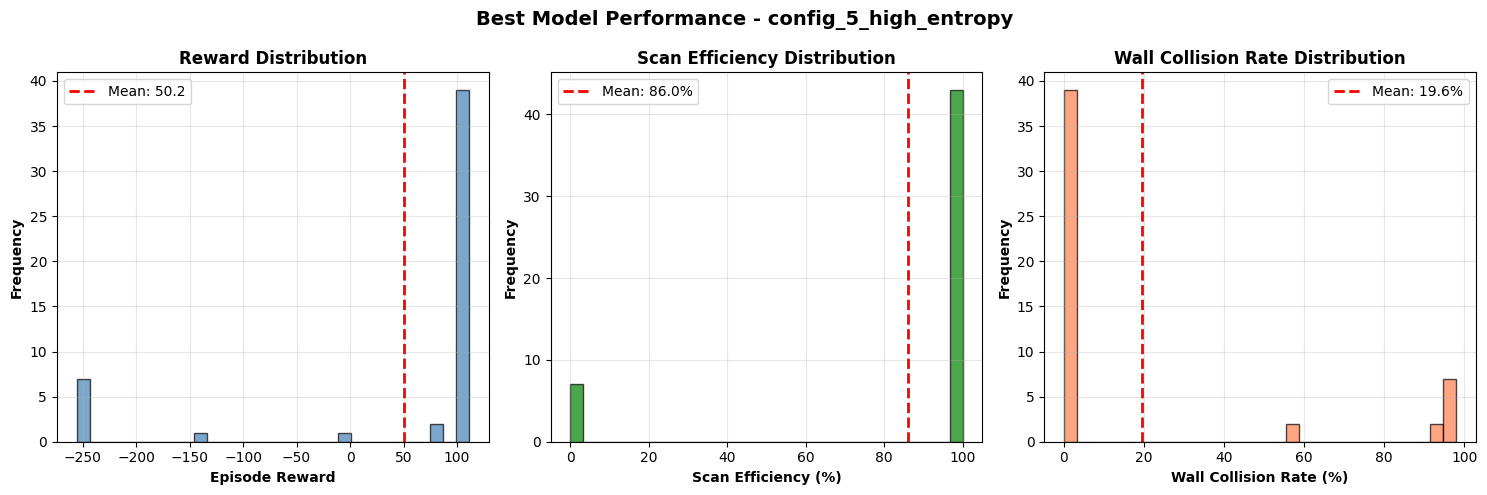

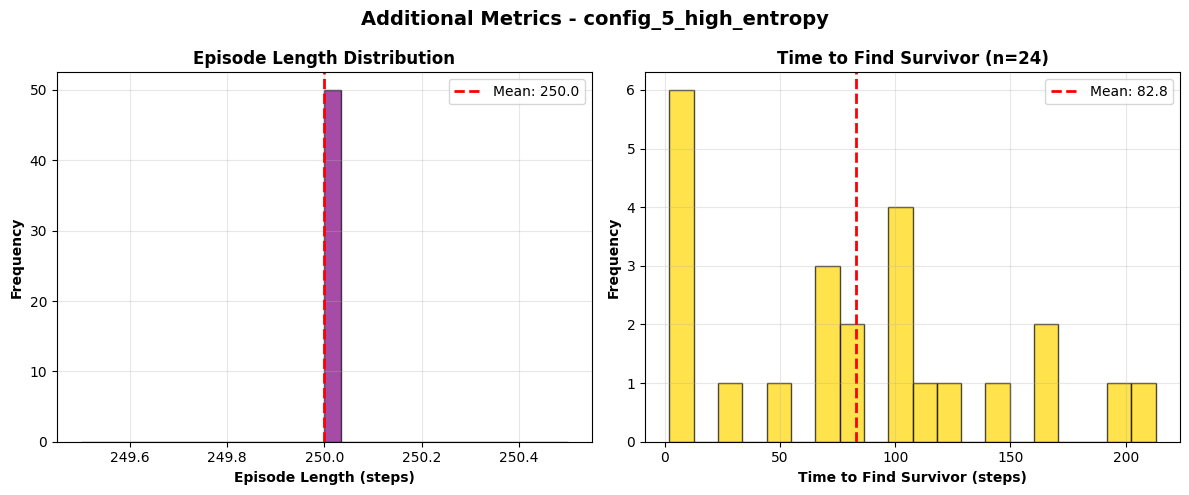


✓ Visualization completed

Note: This cell loads from saved episode data.
To re-evaluate the model with new episodes, load and run the model manually.



In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: VISUALIZE BEST MODEL FROM SAVED DATA
# ═══════════════════════════════════════════════════════════════════════════
# FIXED: Now loads episode data from saved files instead of re-running evaluation
# This cell can be run independently without running Cell 4 or re-evaluating

print(f"\n{'='*120}")
print("VISUALIZING BEST MODEL PERFORMANCE FROM SAVED DATA")
print(f"{'='*120}\n")

# Load best config info (if not already loaded from Cell 6)
if 'best_config_name' not in locals():
    models_dir = Path("../models/a2c")
    loaded_results = {}
    
    config_dirs = [d for d in models_dir.iterdir() if d.is_dir() and d.name.startswith('config_')]
    
    for config_dir in config_dirs:
        config_name = config_dir.name
        results_file = config_dir / "results.json"
        
        if results_file.exists():
            with open(results_file, 'r') as f:
                result_data = json.load(f)
            loaded_results[config_name] = result_data
    
    best_config_name = max(loaded_results.keys(), 
                           key=lambda k: loaded_results[k]['mean_reward'])

# Load episode data from saved npz file
episode_data_path = Path(f"../models/a2c/{best_config_name}/episode_data.npz")
results_path = Path(f"../models/a2c/{best_config_name}/results.json")

if not episode_data_path.exists():
    print(f"❌ ERROR: Episode data not found at {episode_data_path}")
    print("Please run Cell 4 first to train and save the models.")
else:
    # Load the data
    data = np.load(episode_data_path)
    episode_rewards = data['episode_rewards']
    episode_lengths = data['episode_lengths']
    wall_collision_rates = data['wall_collision_rates']
    scan_efficiencies = data['scan_efficiencies']
    pickup_attempts = data['pickup_attempts']
    time_to_find_survivor = data['time_to_find_survivor']
    
    with open(results_path, 'r') as f:
        results_summary = json.load(f)
    
    n_eval_episodes = len(episode_rewards)
    
    # Statistics
    print(f"Configuration: {best_config_name}")
    print(f"Episodes: {n_eval_episodes}")
    print(f"Mean Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"Min/Max Reward: {np.min(episode_rewards):.2f} / {np.max(episode_rewards):.2f}")
    print(f"Mean Episode Length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
    print(f"Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
    print(f"Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
    print(f"Avg Pickup Attempts: {np.mean(pickup_attempts):.2f}")
    if len(time_to_find_survivor) > 0:
        print(f"Survivors Found: {len(time_to_find_survivor)}/{n_eval_episodes}")
        print(f"Avg Time to Find Survivor: {np.mean(time_to_find_survivor):.1f} steps")
    
    # Create evaluation visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Best Model Performance - {best_config_name}', 
                fontsize=14, fontweight='bold')
    
    # 1. Reward Distribution
    axes[0].hist(episode_rewards, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(episode_rewards), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(episode_rewards):.1f}')
    axes[0].set_xlabel('Episode Reward', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Reward Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 2. Scan Efficiency distribution
    axes[1].hist(scan_efficiencies*100, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[1].axvline(np.mean(scan_efficiencies)*100, color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(scan_efficiencies)*100:.1f}%')
    axes[1].set_xlabel('Scan Efficiency (%)', fontweight='bold')
    axes[1].set_ylabel('Frequency', fontweight='bold')
    axes[1].set_title('Scan Efficiency Distribution', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # 3. Wall Collision Rate distribution
    axes[2].hist(wall_collision_rates*100, bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[2].axvline(np.mean(wall_collision_rates)*100, color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(wall_collision_rates)*100:.1f}%')
    axes[2].set_xlabel('Wall Collision Rate (%)', fontweight='bold')
    axes[2].set_ylabel('Frequency', fontweight='bold')
    axes[2].set_title('Wall Collision Rate Distribution', fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional metrics visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Additional Metrics - {best_config_name}', fontsize=14, fontweight='bold')
    
    # 4. Episode Length Distribution
    axes[0].hist(episode_lengths, bins=30, color='purple', alpha=0.7, edgecolor='black')
    axes[0].axvline(np.mean(episode_lengths), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(episode_lengths):.1f}')
    axes[0].set_xlabel('Episode Length (steps)', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Episode Length Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 5. Time to Find Survivor (for successful episodes)
    if len(time_to_find_survivor) > 0:
        axes[1].hist(time_to_find_survivor, bins=20, color='gold', alpha=0.7, edgecolor='black')
        axes[1].axvline(np.mean(time_to_find_survivor), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(time_to_find_survivor):.1f}')
        axes[1].set_xlabel('Time to Find Survivor (steps)', fontweight='bold')
        axes[1].set_ylabel('Frequency', fontweight='bold')
        axes[1].set_title(f'Time to Find Survivor (n={len(time_to_find_survivor)})', fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No survivors found\nin evaluation episodes', 
                    ha='center', va='center', fontsize=12, transform=axes[1].transAxes)
        axes[1].set_title('Time to Find Survivor', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization completed")
    print(f"{'='*120}")
    print("\nNote: This cell loads from saved episode data.")
    print("To re-evaluate the model with new episodes, load and run the model manually.")
    print(f"{'='*120}\n")